This notebook is to analyse the labels and their relationships, without downloading the images.

In [69]:
from commonconstants import *
import pandas as pd
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import itertools
import os
import json
%matplotlib notebook 

In [70]:
#Utility method to read the data pickle
def read_dataset(filename):
    return pd.read_pickle(filename)

We first start by creating the label to image mapping dataframe.
The below method takes the data json and create a flat structure of `[Imageid, LabelId]`

In [71]:
def create_label_pickle(JSONFILENAME, OUTPUTFILENAME):
    with open(JSONFILENAME) as data_file:
        data = json.load(data_file)
    dataset = []
    annotations = data['annotations']
    for annotation in annotations:
        labels = list(annotation['labelId'])
        for label in labels:
            a = {}
            a['imageId'] = annotation['imageId']
            a['labelId'] = label
            dataset.append(a)
    panda = pd.DataFrame(dataset)
    print(panda.head())
    panda.to_pickle(OUTPUTFILENAME)

In [72]:
TEST_PICKLE = './data/test.pickle'
TRAIN_PICKLE = './data/train.pickle'
VALIDATION_PICKLE = './data/validation.pickle'
TRAIN_LABEL_PICKLE = './data/train_label.pickle'
VALIDATION_LABEL_PICKLE = './data/validation_label.pickle'

if os.path.isfile(VALIDATION_LABEL_PICKLE) == False:
    create_label_pickle(VALIDATION_FILE, VALIDATION_LABEL_PICKLE)
if os.path.isfile(TRAIN_LABEL_PICKLE) == False:
    create_label_pickle(TRAIN_FILE, TRAIN_LABEL_PICKLE)

In [73]:
dataset = read_dataset('./data/train_label.pickle')
dataset = pd.DataFrame(dataset, dtype='int32')

Now that we have the required structure we start with some basic analysis.
1. The number of distinct labels in the dataset.
2. The maximum labelId value [This will be used later].
3. The number of distinct images in the dataset.

In [74]:
number_of_labels = dataset['labelId'].nunique() # Number of distinct labels
maximum_label_id = max(dataset['labelId']) # The maximum labelId value
number_of_images = dataset['imageId'].nunique() # Number of distinct images
print('Number of distinct labels in the dataset : ', number_of_labels)
print('Maximum id if labels in the dataset : ', maximum_label_id)
print('Number of distinct images in the dataset : ', number_of_images)

Number of distinct labels in the dataset :  228
Maximum id if labels in the dataset :  228
Number of distinct images in the dataset :  1014544


One of the simplest analysis of the dataset can be done through counts. Let us start by creating counts of labels and images. This can easily be done using `pandas.groupby` method provided out of the box.

In [75]:
# Count analysis for images
count_by_image_id = dataset.groupby('imageId')['imageId'].count().reset_index(name="count")
count_by_label_id = dataset.groupby('labelId')['labelId'].count().reset_index(name="count")

Let us start by simple largest and smallest counts.

In [76]:
# Plot by label counts
print('Images with largest number of labels ')
count_by_image_id.nlargest(5, 'count')

Images with largest number of labels 


,imageId,count
9620,9621,23
84880,84881,23
107767,107768,23
134432,134433,23
169914,169915,23


This tells us that maximum number of labels is < 25 . This is not much given we have 200+ labels. 
This laso gives us a rough idea how many labels we may have to predict for test images.

One other aspect of it to see how many images have high number of labels.
We can get and ideas by plotting the counts in a bar graph.

 Number of labels versus number of images with that many labels :


<IPython.core.display.Javascript object>


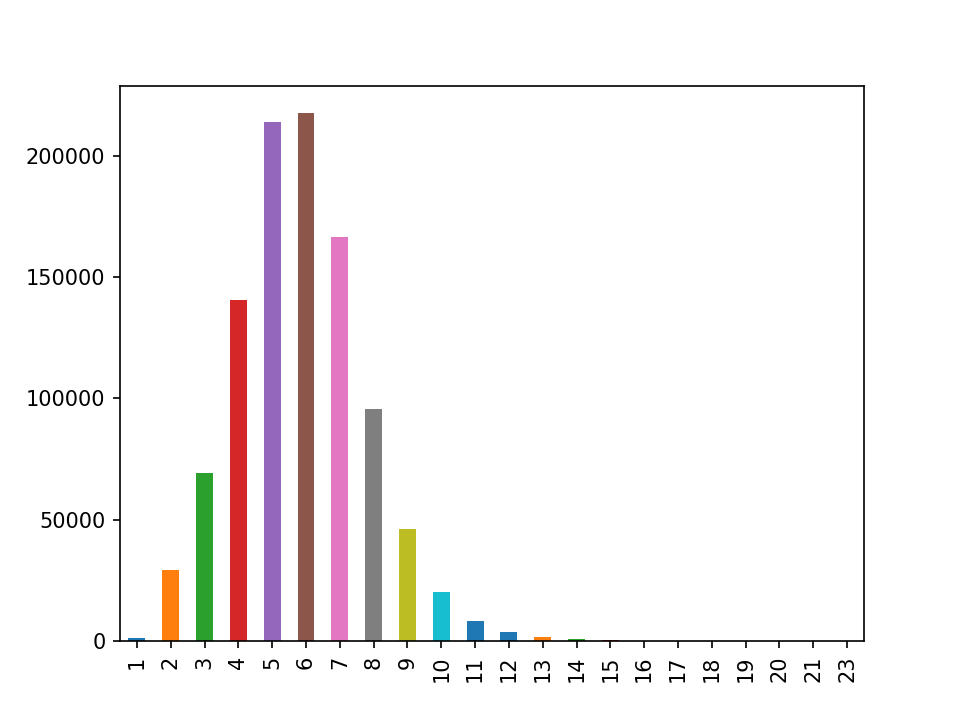

In [77]:
print(' Number of labels versus number of images with that many labels :')
a = count_by_image_id['count'].value_counts().sort_index().plot(kind = 'bar')

This plot tells us that most images have between 3 to 9 labels. It is nice to get a near normal distribution as well :)
Next we can do a similar analysis for labels also.

In [78]:
# Plot by label counts
print('Labels associated with largest number of images ')
count_by_label_id.nlargest(5, 'count')

Labels associated with largest number of images 


,labelId,count
65,66,743250
104,105,330864
152,153,261844
16,17,251869
170,171,243038


Looks like label 66, 105 and 153 are the most occuring labels in the dataset. We can get a rough idea of all labels by plotting labelId with the count.

<IPython.core.display.Javascript object>


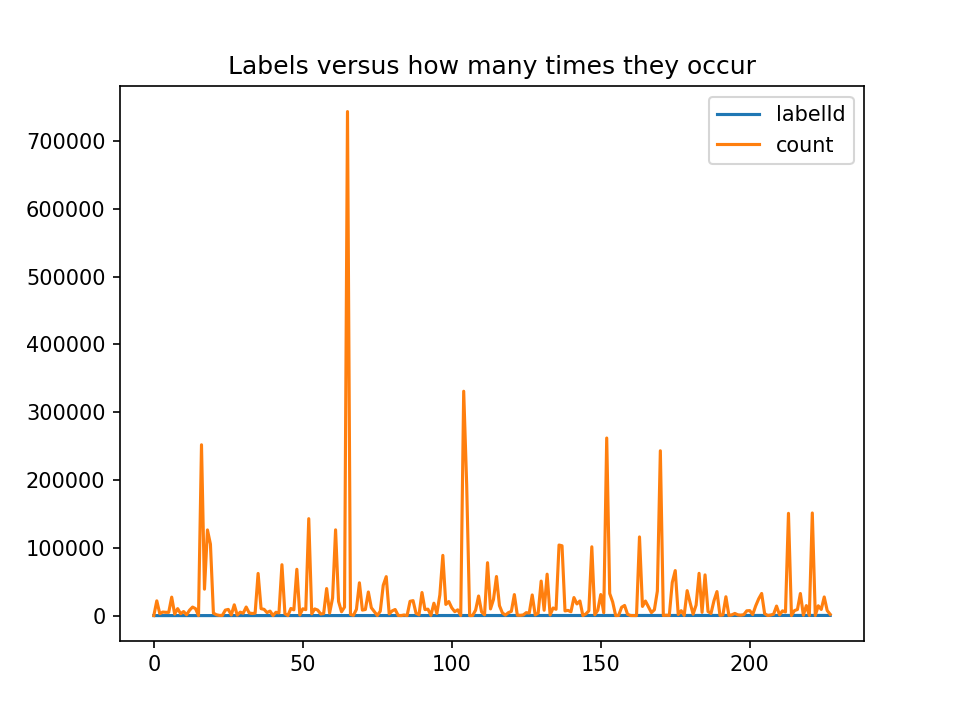

In [79]:
count_by_label_id.plot(title='Labels versus how many times they occur')

There are some labels are clearly occur more than the other. We can correlate them back to the actual images later and see what they could be.

One another aspect of labels is that they may occur together with other labels. It may tell us that they may be some how related. For example, ties may occur frequently with suits, shoes may occur often with socks etc. 

We can get this information by creating `NLabel * NLabel` matrix with zero values.
Here NLabel is the maximum labelId.
We increment `[i,j]` whenever `label i` and `label j` occur together. 
Disclaimer : The below piece is a slow and crude way to do this. If you find a more optimised way to do the same thing, mention in comments.

In [80]:
check_relation = np.zeros((maximum_label_id + 1 ,maximum_label_id + 1)) # adding one because labels are 1 indexed.
# we start by creating a dict with imageId as keys and list of labels as values.
relations = {}
for index, row in dataset.iterrows():
    imageId = row['imageId']
    labelId = row['labelId']
    if imageId in relations:
        # if this imageId is already there, map this label to all other labels already encountered.
        for l in relations[imageId]:
            check_relation[l][labelId] += 1
            check_relation[labelId][l] += 1
    else:
        # add this imageId to dict
        relations[imageId] = []
    # add this label to the imageId label's list
    relations[imageId].append(labelId)

In [81]:
# I am creating a clone here becasue in next few steps I am going to sort the matrix.
# I want to retain the original mappings also.
temp = np.copy(check_relation)

In [82]:
# Revert step in case I screw up later.
#check_relation = np.copy(temp)

Let us see what we have in the relations. Let us take labelId 10 for example.

In [83]:
check_relation[10, :]

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 4.500e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 5.700e+01, 1.338e+03, 0.000e+00, 7.710e+02,
       5.000e+00, 3.070e+02, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 1.300e+01, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.100e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       2.000e+00, 1.300e+01, 1.000e+01, 1.000e+01, 0.000e+00, 8.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 9.300e+01,
       0.000e+00, 3.600e+01, 3.500e+01, 0.000e+00, 1.000e+00, 2.000e+00,
       0.000e+00, 0.000e+00, 5.600e+01, 0.000e+00, 2.000e+01, 0.000e+00,
       2.758e+03, 0.000e+00, 0.000e+00, 0.000e+00, 9.500e+01, 3.000e+00,
       4.240e+02, 0.000e+00, 4.000e+00, 7.000e+00, 0.000e+00, 8.000e+00,
       1.900e+01, 1.380e+02, 1.100e+01, 0.000e+00, 

We notice that label 10 occurs most frequently , 87 times, along-side label 66.

Let us use the `numpy.argsort` method to get the indices in sorted order.
argsort does not actually sort the array but gives us the indices if the array were sorted.
So for an array `[10 ,2 , 100, 4] ` it gives `[1, 3, 0, 2]`
In our case this indices are just labelIds of other labels.

In [84]:
closest_companions = np.argsort(temp, axis=1) # axis = 1 to sort along the rows.
# Here I am filtering just the last three columns which have the highest values. 
# [:,::-1] is to reverse the three values because the values occur in ascending order 
# and I wanted them in descending
closest_companions = (closest_companions[:, -3:])[:,::-1]
print(closest_companions[10])

[ 66 176  15]


I also wanted to check how many times a label occuring with its closest comapnion labels.
For this we can simply sort the rows and take the last 3 values.

In [85]:
# the `temp` we created earlier will be used here.
sorted_closest_companions = temp
sorted_closest_companions.sort(axis = 1)
closest_companions_count = (sorted_closest_companions[:, -3:])[:,::-1]
print(closest_companions_count[10])

[2758. 1593. 1338.]


The above two lists can together give us the closest companions for each label and how many times they occur together.

I will go ahead and make dataframe out of these arrays, for the most occuring companion.

In [86]:
companion = pd.DataFrame(columns=['companion'],data = closest_companions[1:,0], index = range(1, closest_companions.shape[0]))
companion['labelId'] = range(1, closest_companions.shape[0])
companion.head()

,companion,labelId
1,105,1
2,66,2
3,106,3
4,66,4
5,153,5


In [87]:
# I am taking closest_companions_count[1:,0] because
# the matrix indexing starts from 0 and we dont have a labelid = 1 in dataset.
# So no use keepin that value
companion_count = pd.DataFrame(dtype='int32',columns=['count'],data = closest_companions_count[1:,0], index = range(1, closest_companions_count.shape[0]))
companion_count['labelId'] = range(1, closest_companions_count.shape[0])
companion_count.head()

,count,labelId
1,57,1
2,20425,2
3,1979,3
4,2661,4
5,3791,5


I also wanted to check how often labels occur with their companions, with respect to the dataset.
For example, if `label 1` occurs 100 times in the dataset, and it occurs with `label10` 80 times out of these 100, there may be something going on in there.

I started by plotting the labelId with theire counts in the dataset [something we did earlier too] and then overlaying the number if times they occur with their closest companion.

<IPython.core.display.Javascript object>


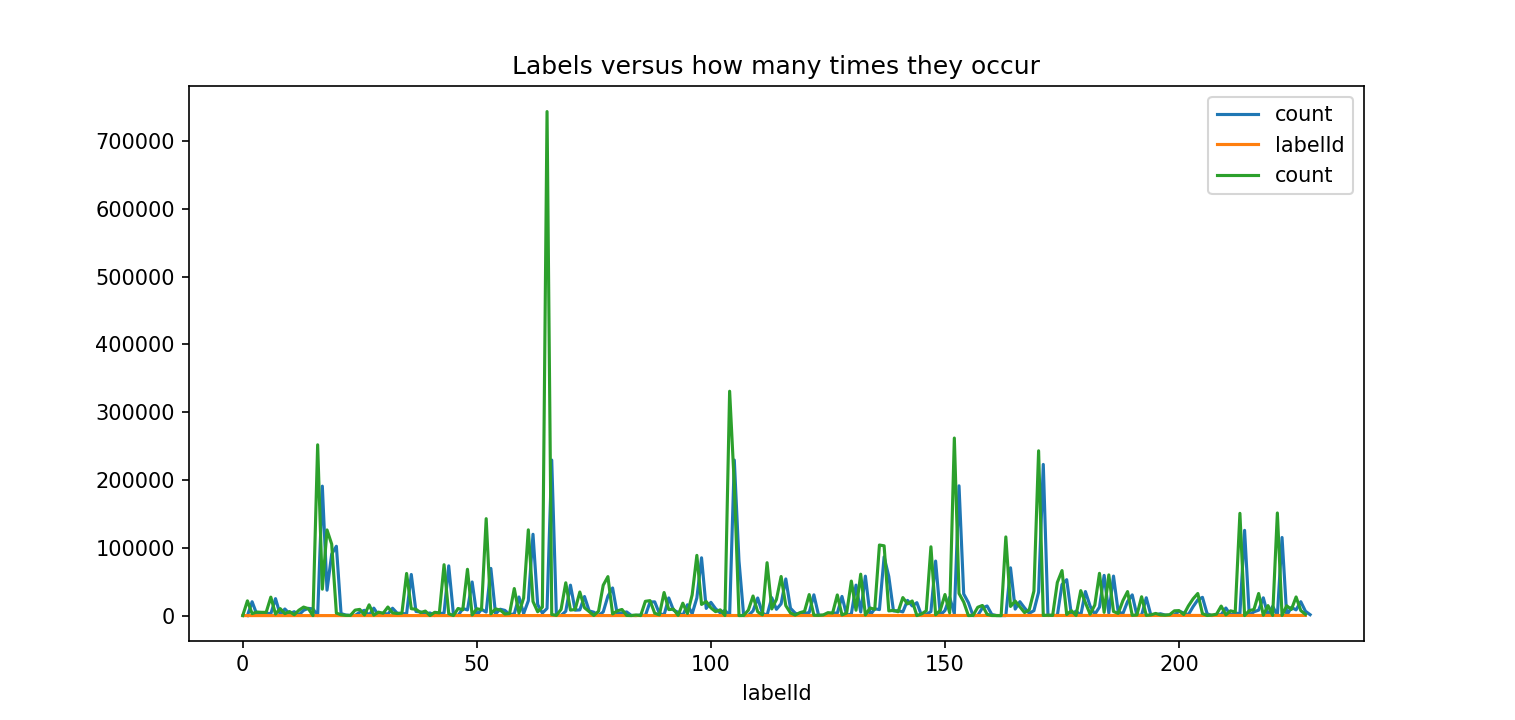

In [88]:
ax = companion_count.plot(title='Labels versus how many times they occur', x='labelId', y='count')
count_by_label_id.plot(ax= ax)

The plot gives a general ideas that two trends are similar, but honestly, it looked weird to follow, so i tried doing it the old-school way.

I started by merging the two data frames we have, labelid versus count in the dataset, and label id versus number of time sit occured with its closest companion.

In [89]:
merged = pd.merge(companion_count, count_by_label_id, on='labelId')
merged.head()

,count_x,labelId,count_y
0,57,1,79
1,20425,2,21754
2,1979,3,2906
3,2661,4,5249
4,3791,5,4837


In [90]:
# renaming columns to something more sensible.
merged.columns = ['companion_count', 'labelId', 'dataset_count']
merged.head()

,companion_count,labelId,dataset_count
0,57,1,79
1,20425,2,21754
2,1979,3,2906
3,2661,4,5249
4,3791,5,4837


Just out of curiosity , lets calculate the percentage of times that happens.

In [91]:
merged['percentage'] = (merged['companion_count'] / merged['dataset_count'] ) * 100
merged.head()

,companion_count,labelId,dataset_count,percentage
0,57,1,79,72.151899
1,20425,2,21754,93.890779
2,1979,3,2906,68.100482
3,2661,4,5249,50.695371
4,3791,5,4837,78.375026


Lets also add the label if of the closest companion

In [92]:
merged = pd.merge(merged, companion, on='labelId')
merged.head()

,companion_count,labelId,dataset_count,percentage,companion
0,57,1,79,72.151899,105
1,20425,2,21754,93.890779,66
2,1979,3,2906,68.100482,106
3,2661,4,5249,50.695371,66
4,3791,5,4837,78.375026,153


As a final touchup, lets reorder the columns.

In [93]:
merged = merged[['labelId', 'dataset_count', 'companion', 'companion_count', 'percentage']]

In [94]:
merged.head()

,labelId,dataset_count,companion,companion_count,percentage
0,1,79,105,57,72.151899
1,2,21754,66,20425,93.890779
2,3,2906,106,1979,68.100482
3,4,5249,66,2661,50.695371
4,5,4837,153,3791,78.375026


You can read this as
`<LabelId>` occurs in the dataset `<dataset_count>` times. Out of these `<dataset_count>` times, it occurs along side `<companion>` label , `<companion_count>` times, i.e, `<percentage>` of all occurances.

    #  Thanks for reading :) 